In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/natural-gas/Nat_Gas.csv


In [4]:
from pmdarima import auto_arima

In [6]:
# Load and prepare data
data = pd.read_csv('../input/natural-gas/Nat_Gas.csv', parse_dates=['Dates'])
data['Prices'] = data['Prices'].apply(lambda x: float(x))
data.set_index('Dates', inplace=True)

<ipython-input-6-44260aaa8529>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('../input/natural-gas/Nat_Gas.csv', parse_dates=['Dates'])


In [7]:
data.head()

,Prices
Dates,
2020-10-31,10.1
2020-11-30,10.3
2020-12-31,11.0
2021-01-31,10.9
2021-02-28,10.9


In [8]:
# Basic data inspection
print("="*50)
print("Data Overview:")
print(f"Time Range: {data.index[0].strftime('%Y-%m-%d')} to {data.index[-1].strftime('%Y-%m-%d')}")
print(f"Total Data Points: {len(data)}")
print("\nMissing Values Check:")
print(data.isnull().sum())
print("\nBasic Statistics:")
print(data.describe())


Data Overview:
Time Range: 2020-10-31 to 2024-09-30
Total Data Points: 48

Missing Values Check:
Prices    0
dtype: int64

Basic Statistics:
          Prices
count  48.000000
mean   11.207083
std     0.757897
min     9.840000
25%    10.650000
50%    11.300000
75%    11.625000
max    12.800000


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

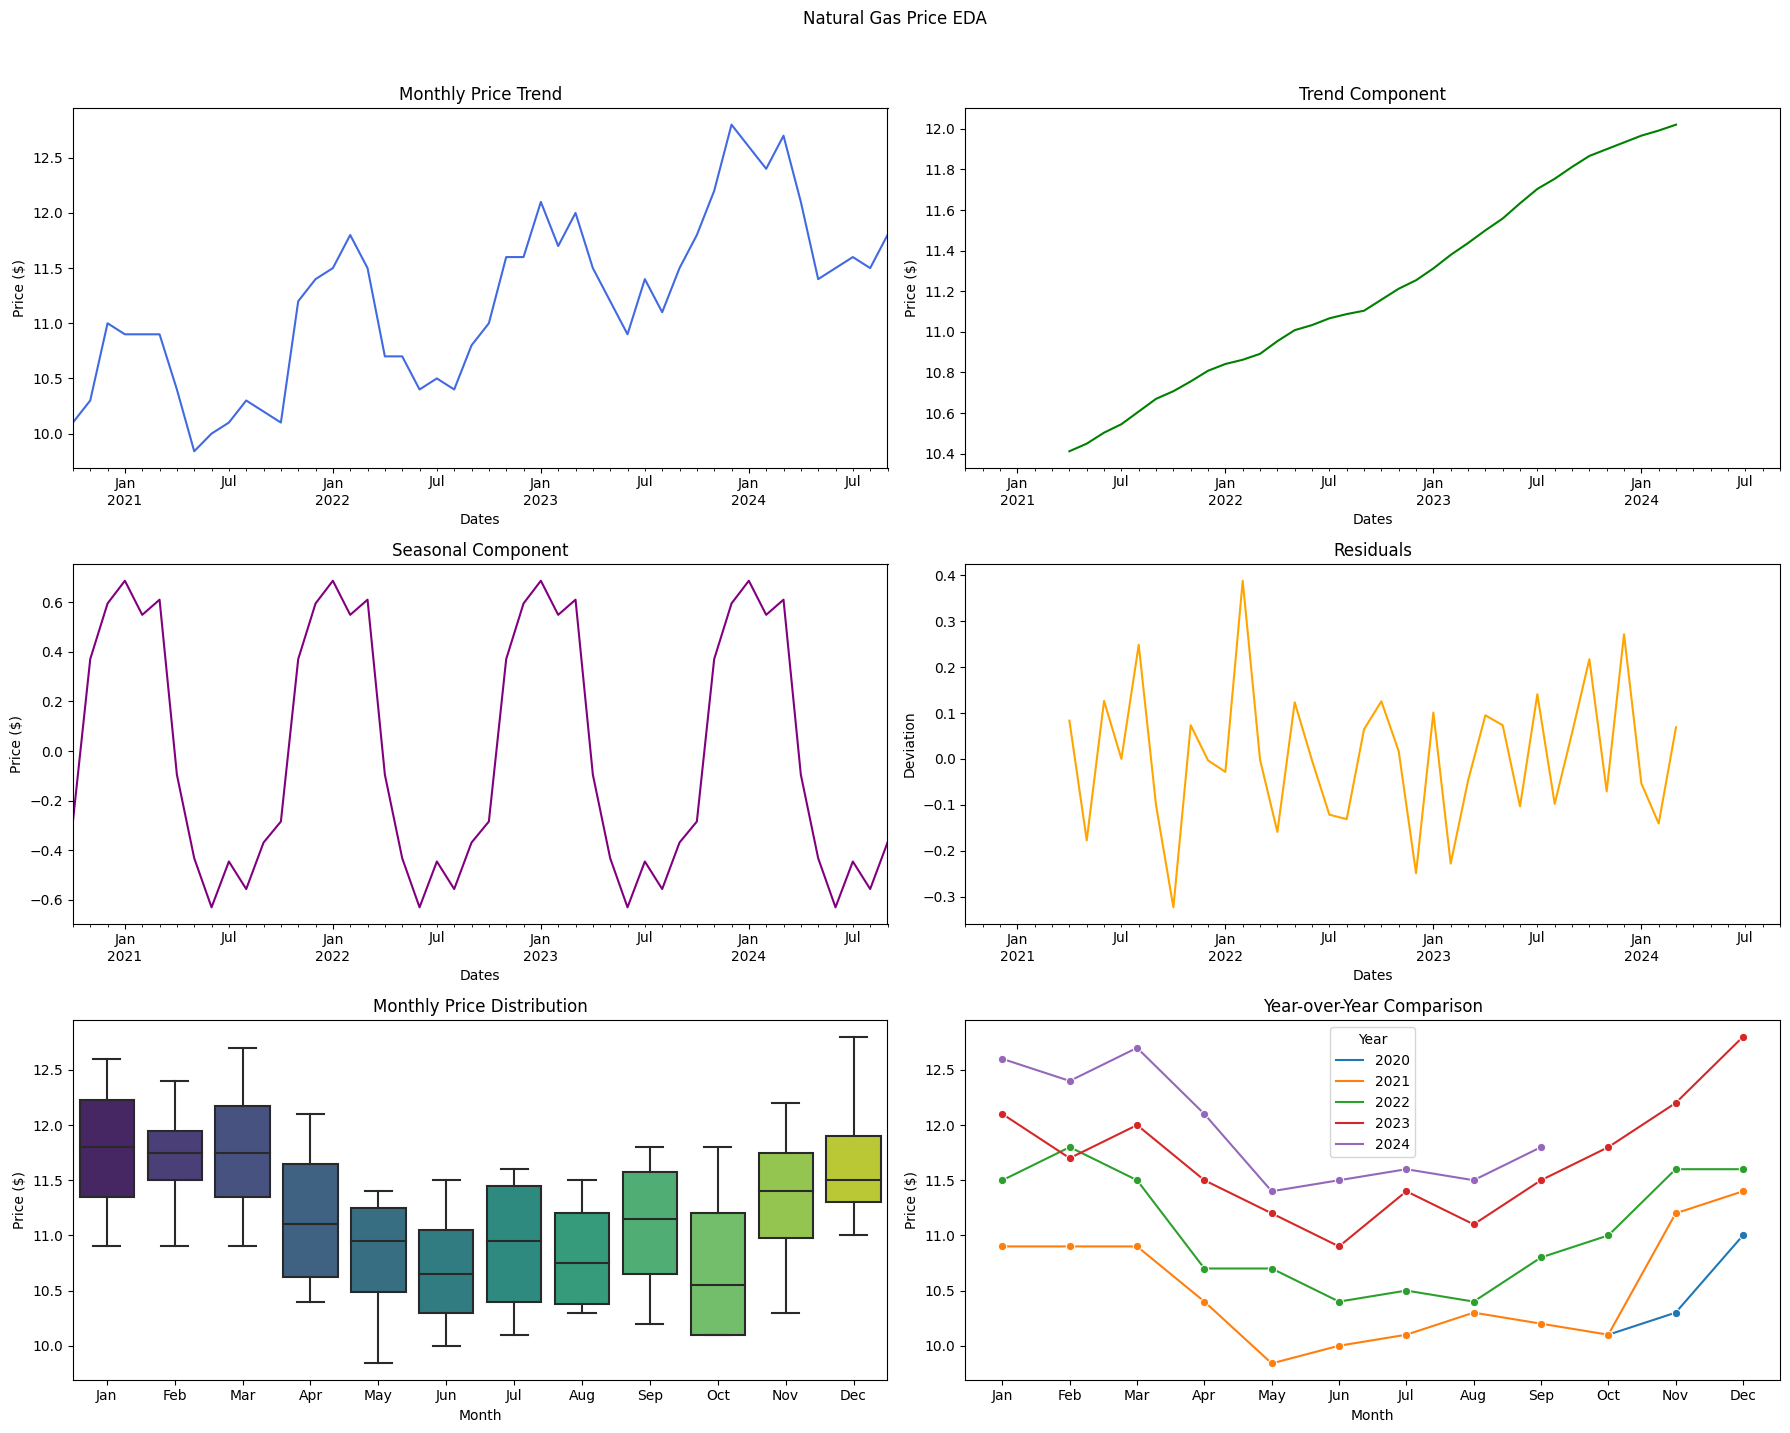


Key Observations:
- Prices show clear annual seasonality with winter peaks
- Long-term trend indicates gradual price escalation
- Notable price spikes in Q4 2023 and Q1 2024
- Summer months typically show lower average prices


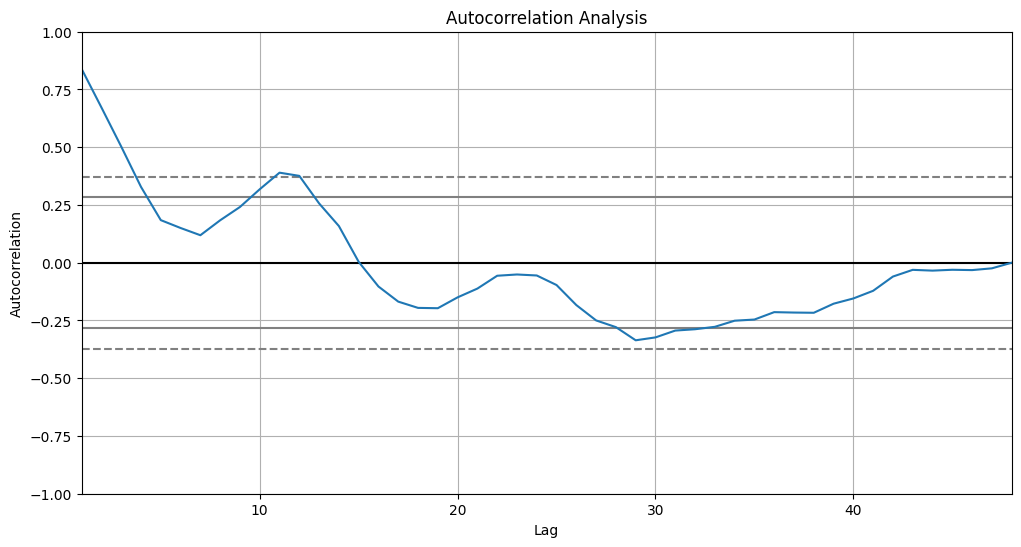

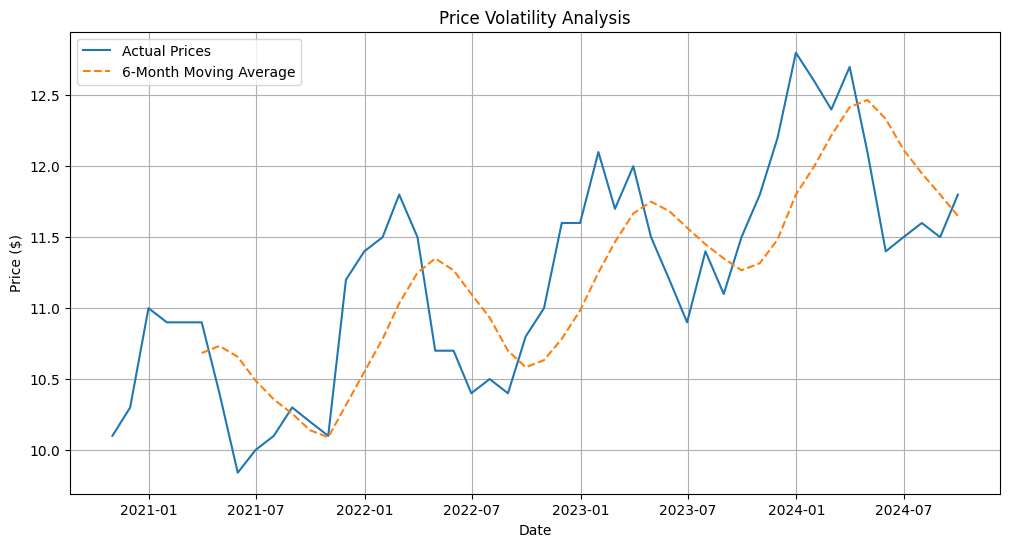

In [9]:
# Time Series Analysis
plt.figure(figsize=(18, 14))
plt.suptitle('Natural Gas Price EDA', y=1.02)

# Raw time series plot
ax1 = plt.subplot(3, 2, 1)
data['Prices'].plot(color='royalblue', title='Monthly Price Trend')
plt.ylabel('Price ($)')

# Seasonal decomposition
ax2 = plt.subplot(3, 2, 2)
decomposition = seasonal_decompose(data['Prices'], model='additive', period=12)
decomposition.trend.plot(color='green', title='Trend Component')
plt.ylabel('Price ($)')

# Seasonal component
ax3 = plt.subplot(3, 2, 3)
decomposition.seasonal.plot(color='purple', title='Seasonal Component')
plt.ylabel('Price ($)')

# Residuals
ax4 = plt.subplot(3, 2, 4)
decomposition.resid.plot(color='orange', title='Residuals')
plt.ylabel('Deviation')

# Monthly distribution boxplot
ax5 = plt.subplot(3, 2, 5)
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sns.boxplot(x=data.index.month_name().str[:3], y=data['Prices'], 
            order=month_order, palette='viridis')
plt.title('Monthly Price Distribution')
plt.xlabel('Month')
plt.ylabel('Price ($)')

# Yearly comparison
ax6 = plt.subplot(3, 2, 6)
data['Year'] = data.index.year
sns.lineplot(data=data, x=data.index.month, y='Prices', hue='Year', 
             palette='tab10', marker='o')
plt.title('Year-over-Year Comparison')
plt.xlabel('Month')
plt.xticks(range(1,13), month_order)
plt.ylabel('Price ($)')

plt.tight_layout()
plt.show()

# Additional analysis
print("\n" + "="*50)
print("Key Observations:")
print("- Prices show clear annual seasonality with winter peaks")
print("- Long-term trend indicates gradual price escalation")
print("- Notable price spikes in Q4 2023 and Q1 2024")
print("- Summer months typically show lower average prices")

# Correlation analysis
plt.figure(figsize=(12, 6))
pd.plotting.autocorrelation_plot(data['Prices'])
plt.title('Autocorrelation Analysis')
plt.show()

# Rolling statistics
rolling_window = 6
plt.figure(figsize=(12, 6))
plt.plot(data['Prices'], label='Actual Prices')
plt.plot(data['Prices'].rolling(rolling_window).mean(), 
         label=f'{rolling_window}-Month Moving Average', linestyle='--')
plt.title('Price Volatility Analysis')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Force-diagnose stationarity (ADF Test)
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')
    print(f'Stationary: {"Yes" if result[1] < 0.05 else "No"}')

print("Original Series:")
adf_test(data['Prices']) 

Original Series:
ADF Statistic: 0.218
p-value: 0.973
Stationary: No


In [11]:
# Explicitly extract the target series
price_series = data['Prices']  

model = auto_arima(data['Prices'],
                   seasonal=True,
                   m=12,            # Annual seasonality
                   d=1,             # First-order differencing (fix trend)
                   D=1,             # Seasonal differencing (fix seasonality)
                   start_p=0, start_q=0,
                   max_order=5,     # Prevent overfitting
                   stepwise=True,
                   suppress_warnings=True,
                   trace=True)      # Show model search process

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=36.460, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=21.605, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=25.917, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.97 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=34.778, Time=0.06 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=15.104, Time=0.10 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=19.665, Time=0.06 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=8.260, Time=0.41 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.36 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(

In [12]:
# Test first difference + seasonal difference
diff_series = data['Prices'].diff().diff(12).dropna()
adf_test(diff_series)

ADF Statistic: -8.068
p-value: 0.000
Stationary: Yes


In [13]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood                   0.870
Date:                            Fri, 24 Jan 2025   AIC                              8.260
Time:                                    06:23:02   BIC                             16.037
Sample:                                10-31-2020   HQIC                            10.944
                                     - 09-30-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7655      0.185     -4.148      0.000      -1.127      -0.404
ar.L2         -0.4605      0.173   

In [28]:
# Generate historical daily prices through linear interpolation
historical_daily = data.resample('D').asfreq()
historical_daily_interpolated = historical_daily.interpolate(method='linear')

In [29]:
# Forecast next 12 months
forecast, _ = model.predict(n_periods=12, return_conf_int=True)
forecast_dates = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=12, freq='ME')
future_monthly = pd.DataFrame({'Prices': forecast}, index=forecast_dates)

In [37]:
# Generate future daily prices through interpolation
future_daily_dates = pd.date_range(start=forecast_dates[0].replace(day=1), end=forecast_dates[-1], freq='D')
future_daily = future_monthly.reindex(future_daily_dates)
future_daily_interpolated = future_daily.interpolate(method='linear')

In [38]:
# Combine historical and forecast data
full_data = pd.concat([historical_daily_interpolated, future_daily_interpolated])

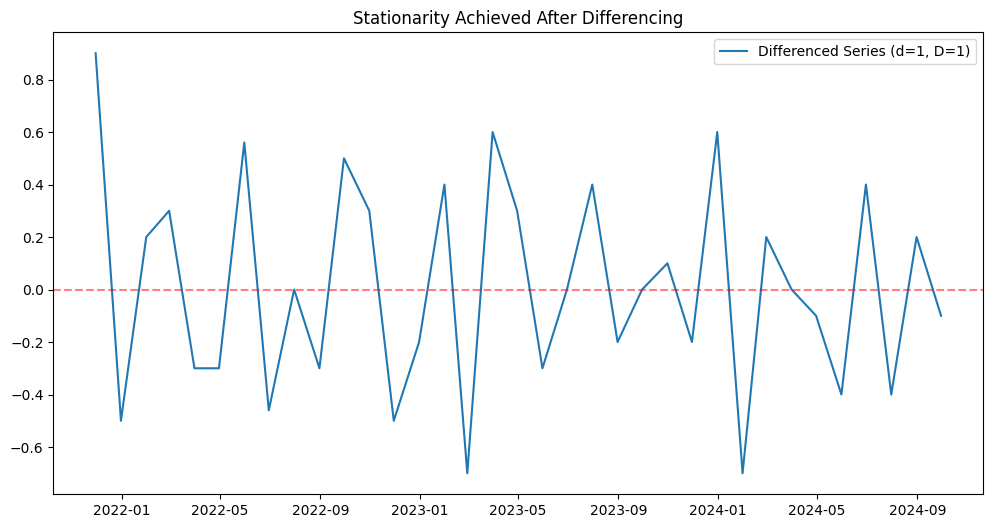

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(diff_series, label='Differenced Series (d=1, D=1)')
plt.axhline(0, color='red', linestyle='--', alpha=0.5)
plt.title('Stationarity Achieved After Differencing')
plt.legend()
plt.show()

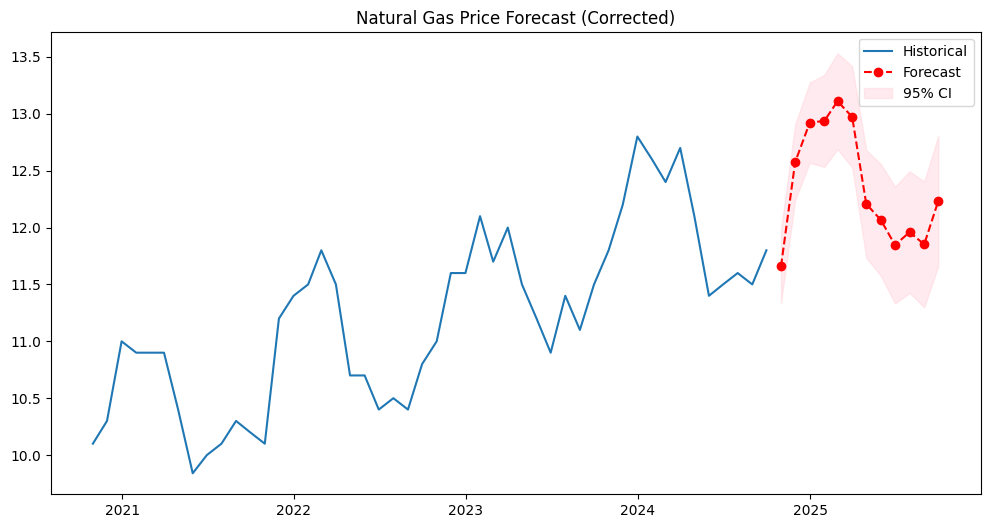

In [40]:
forecast, conf_int = model.predict(n_periods=12, return_conf_int=True)

plt.figure(figsize=(12, 6))
plt.plot(data['Prices'], label='Historical')
plt.plot(forecast_dates, forecast, label='Forecast', 
         color='red', marker='o', linestyle='--')
plt.fill_between(forecast_dates, conf_int[:,0], conf_int[:,1], 
                 color='pink', alpha=0.3, label='95% CI')
plt.title('Natural Gas Price Forecast (Corrected)')
plt.legend()
plt.show()

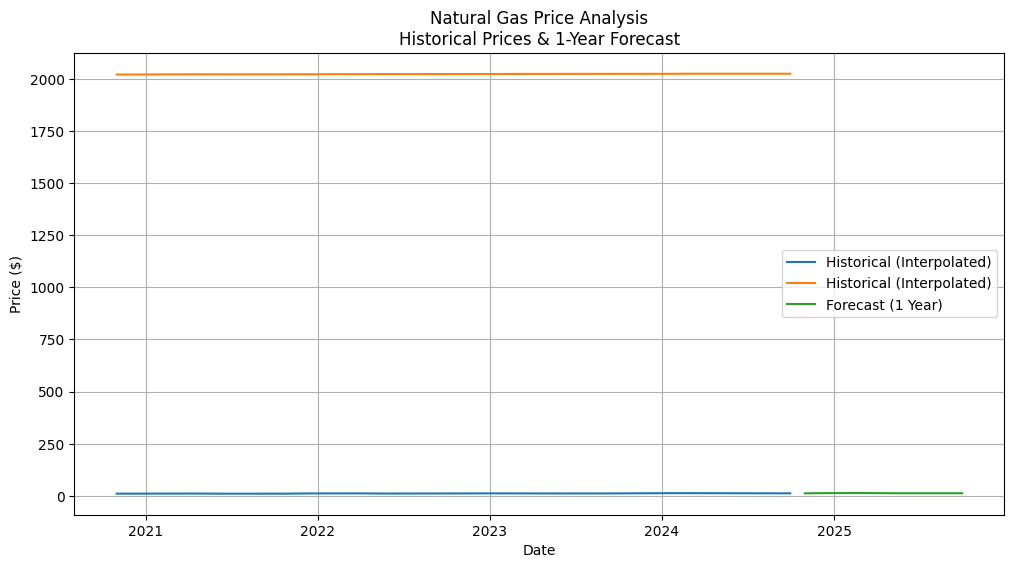

In [41]:
# Visualization
plt.figure(figsize=(12, 6))
plt.plot(historical_daily_interpolated, label='Historical (Interpolated)')
plt.plot(future_daily_interpolated, label='Forecast (1 Year)')
plt.title('Natural Gas Price Analysis\nHistorical Prices & 1-Year Forecast')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
def estimate_price(date_str):
    """Estimate natural gas price for any date between 2020-10-31 and 2025-09-30"""
    try:
        date = pd.to_datetime(date_str)
        if date < full_data.index[0] or date > full_data.index[-1]:
            raise ValueError
        return round(full_data.loc[date, 'Prices'], 2)
    except:
        return f"Date must be between {full_data.index[0].strftime('%Y-%m-%d')} and {full_data.index[-1].strftime('%Y-%m-%d')}"

In [43]:
# Example usage
print(estimate_price('2023-03-15'))  # Interpolated historical
print(estimate_price('2025-05-15'))  # Forecasted future

11.85
12.14
